In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS 
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
from time import time
import datetime

In [2]:
data = pd.read_csv("/Users/guangxinsu/Desktop/penguins_raw.csv")

In [3]:
data.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [4]:
#filter features

In [5]:
data.drop(["Comments","Stage","studyName","Sample Number","Region","Individual ID","Date Egg"],inplace=True,axis=1)
data["Culmen Length (mm)"] = data["Culmen Length (mm)"].fillna(data["Culmen Length (mm)"].mean())
data["Culmen Depth (mm)"] = data["Culmen Depth (mm)"].fillna(data["Culmen Depth (mm)"].mean())
data["Flipper Length (mm)"] = data["Flipper Length (mm)"].fillna(data["Flipper Length (mm)"].mean())
data["Body Mass (g)"] = data["Body Mass (g)"].fillna(data["Body Mass (g)"].mean())
data["Delta 15 N (o/oo)"] = data["Delta 15 N (o/oo)"].fillna(data["Delta 15 N (o/oo)"].mean())
data["Delta 13 C (o/oo)"] = data["Body Mass (g)"].fillna(data["Body Mass (g)"].mean())
data.loc[:,"Sex"]=(data["Sex"]=="male").astype("int")
data.loc[:,"Clutch Completion"]=(data["Clutch Completion"]=="Yes").astype("int")
#Check how many values are turned into lists
labels=data["Island"].unique().tolist()
#Convert letters to number
data["Island"]=data["Island"].apply(lambda x: labels.index(x))
labels = data["Island"].unique().tolist()
data

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Adelie Penguin (Pygoscelis adeliae),0,1,39.10000,18.70000,181.000000,3750.000000,0,8.733382,3750.000000
1,Adelie Penguin (Pygoscelis adeliae),0,1,39.50000,17.40000,186.000000,3800.000000,0,8.949560,3800.000000
2,Adelie Penguin (Pygoscelis adeliae),0,1,40.30000,18.00000,195.000000,3250.000000,0,8.368210,3250.000000
3,Adelie Penguin (Pygoscelis adeliae),0,1,43.92193,17.15117,200.915205,4201.754386,0,8.733382,4201.754386
4,Adelie Penguin (Pygoscelis adeliae),0,1,36.70000,19.30000,193.000000,3450.000000,0,8.766510,3450.000000
...,...,...,...,...,...,...,...,...,...,...
339,Chinstrap penguin (Pygoscelis antarctica),2,1,55.80000,19.80000,207.000000,4000.000000,0,9.704650,4000.000000
340,Chinstrap penguin (Pygoscelis antarctica),2,0,43.50000,18.10000,202.000000,3400.000000,0,9.376080,3400.000000
341,Chinstrap penguin (Pygoscelis antarctica),2,0,49.60000,18.20000,193.000000,3775.000000,0,9.461800,3775.000000
342,Chinstrap penguin (Pygoscelis antarctica),2,1,50.80000,19.00000,210.000000,4100.000000,0,9.980440,4100.000000


In [6]:
#Handling vacancies

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              344 non-null    object 
 1   Island               344 non-null    int64  
 2   Clutch Completion    344 non-null    int64  
 3   Culmen Length (mm)   344 non-null    float64
 4   Culmen Depth (mm)    344 non-null    float64
 5   Flipper Length (mm)  344 non-null    float64
 6   Body Mass (g)        344 non-null    float64
 7   Sex                  344 non-null    int64  
 8   Delta 15 N (o/oo)    344 non-null    float64
 9   Delta 13 C (o/oo)    344 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 27.0+ KB


In [8]:
#Check how many values are turned into lists
labels=data["Species"].unique().tolist()
print(labels)
#Convert letters to number
data["Species"]=data["Species"].apply(lambda x: labels.index(x))
labels = data["Species"].unique().tolist()
data.head(300)

['Adelie Penguin (Pygoscelis adeliae)', 'Gentoo penguin (Pygoscelis papua)', 'Chinstrap penguin (Pygoscelis antarctica)']


,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,0,1,39.10000,18.70000,181.000000,3750.000000,0,8.733382,3750.000000
1,0,0,1,39.50000,17.40000,186.000000,3800.000000,0,8.949560,3800.000000
2,0,0,1,40.30000,18.00000,195.000000,3250.000000,0,8.368210,3250.000000
3,0,0,1,43.92193,17.15117,200.915205,4201.754386,0,8.733382,4201.754386
4,0,0,1,36.70000,19.30000,193.000000,3450.000000,0,8.766510,3450.000000
...,...,...,...,...,...,...,...,...,...,...
295,2,2,1,49.20000,18.20000,195.000000,4400.000000,0,9.271580,4400.000000
296,2,2,1,42.40000,17.30000,181.000000,3600.000000,0,9.351380,3600.000000
297,2,2,1,48.50000,17.50000,191.000000,3400.000000,0,9.426660,3400.000000
298,2,2,0,43.20000,16.60000,187.000000,2900.000000,0,9.354160,2900.000000


In [9]:
data.head(50)

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,0,1,39.10000,18.70000,181.000000,3750.000000,0,8.733382,3750.000000
1,0,0,1,39.50000,17.40000,186.000000,3800.000000,0,8.949560,3800.000000
2,0,0,1,40.30000,18.00000,195.000000,3250.000000,0,8.368210,3250.000000
3,0,0,1,43.92193,17.15117,200.915205,4201.754386,0,8.733382,4201.754386
4,0,0,1,36.70000,19.30000,193.000000,3450.000000,0,8.766510,3450.000000
5,0,0,1,39.30000,20.60000,190.000000,3650.000000,0,8.664960,3650.000000
6,0,0,0,38.90000,17.80000,181.000000,3625.000000,0,9.187180,3625.000000
7,0,0,0,39.20000,19.60000,195.000000,4675.000000,0,9.460600,4675.000000
8,0,0,1,34.10000,18.10000,193.000000,3475.000000,0,8.733382,3475.000000
9,0,0,1,42.00000,20.20000,190.000000,4250.000000,0,9.133620,4250.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              344 non-null    int64  
 1   Island               344 non-null    int64  
 2   Clutch Completion    344 non-null    int64  
 3   Culmen Length (mm)   344 non-null    float64
 4   Culmen Depth (mm)    344 non-null    float64
 5   Flipper Length (mm)  344 non-null    float64
 6   Body Mass (g)        344 non-null    float64
 7   Sex                  344 non-null    int64  
 8   Delta 15 N (o/oo)    344 non-null    float64
 9   Delta 13 C (o/oo)    344 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 27.0 KB


In [11]:
#data and target
x = data.iloc[:,data.columns != "Species"]
y = data.iloc[:,data.columns == "Species"]

In [12]:
#train and test set
Xtrain,Xtest,Ytrain,Ytest = TTS(x,y,test_size=0.3,random_state=420)

In [13]:
reg = XGBR(n_estimators=100).fit(Xtrain,Ytrain) 
reg.predict(Xtest) 
reg.score(Xtest,Ytest) 

0.9175140971181192

In [14]:
#One of the advantages of the tree model: being able to view the importance score of the model, you can use the embedding method for feature selection
#the feature importances
reg.feature_importances_ 

array([4.5520934e-01, 1.1017058e-03, 4.0963203e-01, 9.0594076e-02,
       4.1496810e-02, 1.8036369e-03, 0.0000000e+00, 1.6241733e-04,
       0.0000000e+00], dtype=float32)

In [15]:
#Cross-validation
reg = XGBR(n_estimators=100) 

In [16]:
CVS(reg,Xtrain,Ytrain,cv=5)

array([0.96334981, 0.93413385, 0.964922  , 0.94453331, 0.93087006])

In [17]:
CVS(reg,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

-0.03033896242461126

In [18]:
#Let's take a look at all the model evaluation indicators in sklearn
import sklearn 
sorted(sklearn.metrics.SCORERS.keys())
#random forest
rfr = RFR(n_estimators=100) 
CVS(rfr,Xtrain,Ytrain,cv=5).mean()


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y wa

0.9311744572510993

In [19]:
CVS(rfr,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean() 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y wa

-0.04245666666666666

In [20]:
#linear regression
lr = LinearR()
CVS(lr,Xtrain,Ytrain,cv=5).mean() 

0.7479632602108952

In [21]:
CVS(lr,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

-0.14709472237947832

In [22]:
reg = XGBR(n_estimators=10,silent=False) 
CVS(reg,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

[23:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

-0.03257129469023262

In [23]:

def plot_learning_curve(estimator,title, X, y,
                        ax=None, #Select subgraph
                        ylim=None, #Set the value range of the ordinate
                        cv=None, #cross validation
                        n_jobs=None #Set the thread to use
                        ):
    from sklearn.model_selection import learning_curve 
    import matplotlib.pyplot as plt
    import numpy as np
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv = cv
                                                            ,random_state = 420
                                                            ,n_jobs = n_jobs)
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title) 
    if ylim is not None:
        
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples") 
    ax.set_ylabel("Score")
    ax.grid() #grid
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
             , color="r",label="Training score") 
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
             , color="g",label="Test score")
    ax.legend(loc="best")
    return ax

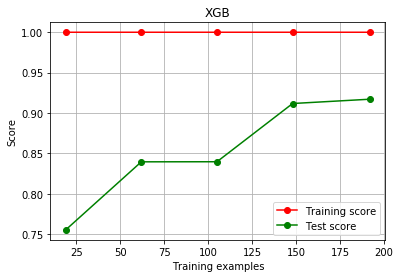

In [24]:
cv = KFold(n_splits=5, shuffle = True, random_state=42)
plot_learning_curve(XGBR(n_estimators=500,random_state=420)
                    ,"XGB",Xtrain,Ytrain,ax=None,cv=cv)
plt.show()

In [25]:
#from the above learning-curve:overfitting!!!!

110 0.917070470188386


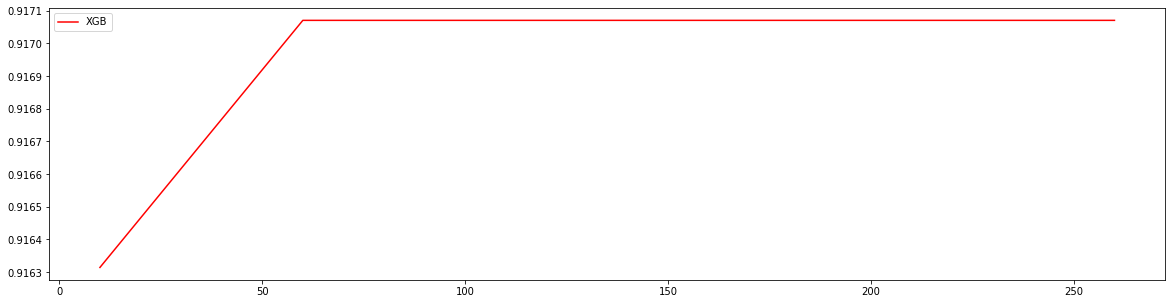

In [26]:
#Observe the influence of n_eatimators on the model by using a parameter learning curve
axisx = range(10,310,50)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    rs.append(CVS(reg,Xtrain,Ytrain,cv=cv).mean()) 
print(axisx[rs.index(max(rs))],max(rs)) 
plt.figure(figsize=(20,5)) 
plt.plot(axisx,rs,c="red",label="XGB") 
plt.legend()
plt.show()

In [27]:
#Evolutionary learning curve, variance and generalization error

In [28]:
#Verify that the model effect has improved?
time0 = time() 
print(XGBR(n_estimators=1,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest)) 
print(time()-time0)
time0 = time() 
print(XGBR(n_estimators=10,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest)) 
print(time()-time0)

time0 = time() 
print(XGBR(n_estimators=40,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest)) 
print(time()-time0)
time0 = time() 
print(XGBR(n_estimators=110,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest)) 
print(time()-time0)

time0 = time() 
print(XGBR(n_estimators=300,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest)) 
print(time()-time0)


0.4343177778791587
0.009416818618774414
0.9160991184463382
0.020000219345092773
0.9175139811105371
0.010956048965454102
0.9175140971181192
0.014415979385375977
0.9175140971181192
0.03157496452331543


[23:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parame

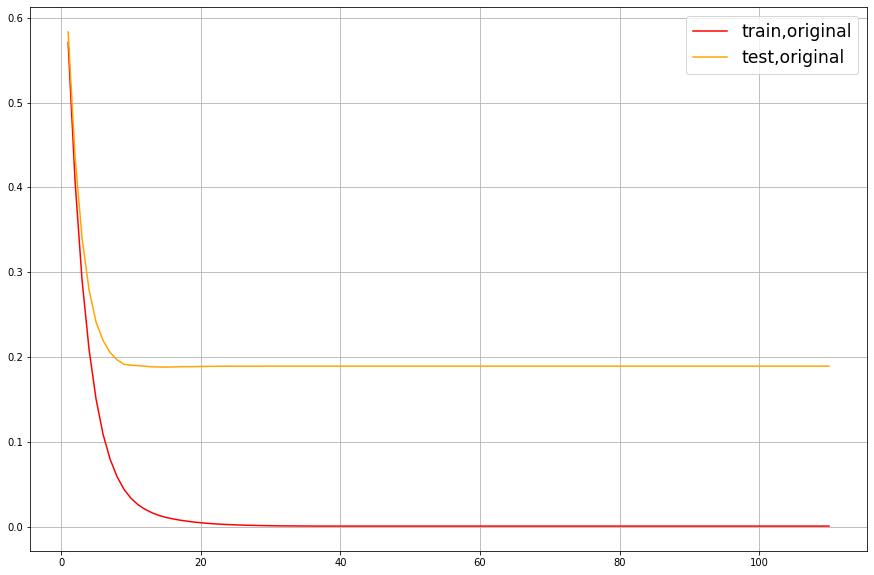

In [29]:
dfull = xgb.DMatrix(x,y)
param1 = {'silent':True 
          ,'obj':'reg:linear' 
,"subsample":1 ,"max_depth":6 ,"eta":0.3
,"gamma":0
,"lambda":1
,"alpha":0 ,"colsample_bytree":1 ,"colsample_bylevel":1 ,"colsample_bynode":1 ,"nfold":5}
num_round = 110
time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
fig,ax = plt.subplots(1,figsize=(15,10))
#ax.set_ylim(top=5)
ax.grid()
ax.plot(range(1,111),cvresult1.iloc[:,0],c="red",label="train,original") 
ax.plot(range(1,111),cvresult1.iloc[:,2],c="orange",label="test,original") 
ax.legend(fontsize="xx-large")
plt.show()

[23:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parame

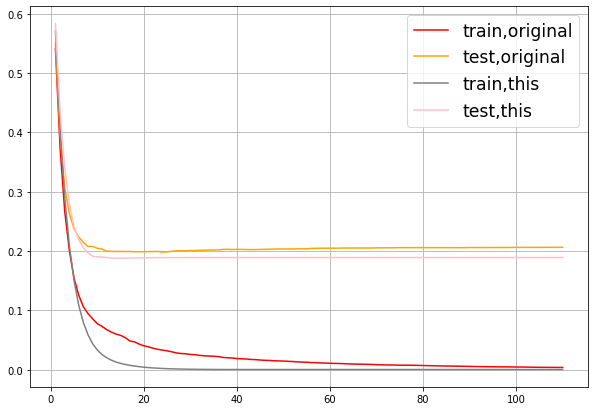

In [30]:
param1 = {'silent':True 
            ,'obj':'reg:linear' 
            ,"subsample":1
            ,"max_depth":3 
            ,"eta":0.35
            ,"gamma":0
            ,"lambda":1
            ,"alpha":0 
            ,"colsample_bytree":1 
            ,"colsample_bylevel":1 
            ,"colsample_bynode":1 
            ,"nfold":5}
num_round = 110
time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
fig,ax = plt.subplots(1,figsize=(10,7))
#ax.set_ylim(top=5)
ax.grid()
ax.plot(range(1,111),cvresult1.iloc[:,0],c="red",label="train,original") 
ax.plot(range(1,111),cvresult1.iloc[:,2],c="orange",label="test,original") 
param2 = {'silent':True
          ,'obj':'reg:linear'
          ,"nfold":5}
param3 = {'silent':True
          ,'obj':'reg:linear'
          ,"nfold":5}
time0 = time()
cvresult2 = xgb.cv(param2, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
time0 = time()
cvresult3 = xgb.cv(param3, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
ax.plot(range(1,111),cvresult3.iloc[:,0],c="gray",label="train,this") 
ax.plot(range(1,111),cvresult3.iloc[:,2],c="pink",label="test,this") 
ax.legend(fontsize="xx-large")
plt.show()

In [31]:
import pickle
dtrain = xgb.DMatrix(Xtrain,Ytrain)
param = {'silent':True 
            ,'obj':'reg:linear' 
            ,"subsample":1
            ,"max_depth":3 
            ,"eta":0.35
            ,"gamma":0
            ,"lambda":1
            ,"alpha":0 
            ,"colsample_bytree":1 
            ,"colsample_bylevel":1 
            ,"colsample_bynode":1 
            ,"nfold":5}
num_round = 110
bst = xgb.train(param,dtrain,num_round)
pickle.dump(bst,open("xgboostonboston.dat","wb"))
import sys
sys.path

[23:44:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




['/Users/guangxinsu/Desktop/ml',
 '/opt/anaconda3/lib/python37.zip',
 '/opt/anaconda3/lib/python3.7',
 '/opt/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/opt/anaconda3/lib/python3.7/site-packages',
 '/opt/anaconda3/lib/python3.7/site-packages/aeosa',
 '/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/guangxinsu/.ipython']

In [11]:
from sklearn.model_selection import train_test_split as TTS 
from sklearn.metrics import mean_squared_error as MSE 
import pickle
import xgboost as xgb
import pandas as pd
data = pd.read_csv("/Users/guangxinsu/Desktop/penguins_raw.csv")
data.drop(["Comments","Stage","studyName","Sample Number","Region","Individual ID","Date Egg"],inplace=True,axis=1)
data["Culmen Length (mm)"] = data["Culmen Length (mm)"].fillna(data["Culmen Length (mm)"].mean())
data["Culmen Depth (mm)"] = data["Culmen Depth (mm)"].fillna(data["Culmen Depth (mm)"].mean())
data["Flipper Length (mm)"] = data["Flipper Length (mm)"].fillna(data["Flipper Length (mm)"].mean())
data["Body Mass (g)"] = data["Body Mass (g)"].fillna(data["Body Mass (g)"].mean())
data["Delta 15 N (o/oo)"] = data["Delta 15 N (o/oo)"].fillna(data["Delta 15 N (o/oo)"].mean())
data["Delta 13 C (o/oo)"] = data["Body Mass (g)"].fillna(data["Body Mass (g)"].mean())
data.loc[:,"Sex"]=(data["Sex"]=="male").astype("int")
data.loc[:,"Clutch Completion"]=(data["Clutch Completion"]=="Yes").astype("int")
#Check how many values are turned into lists
labels=data["Species"].unique().tolist()
print(labels)
#Convert letters to number
data["Species"]=data["Species"].apply(lambda x: labels.index(x))
labels = data["Species"].unique().tolist()
data.head(300)
#Check how many values are turned into lists
labels=data["Island"].unique().tolist()
#Convert letters to number
data["Island"]=data["Island"].apply(lambda x: labels.index(x))
labels = data["Island"].unique().tolist()
data
x = data.iloc[:,data.columns != "Species"]
y = data.iloc[:,data.columns == "Species"]
Xtrain,Xtest,Ytrain,Ytest = TTS(x,y,test_size=0.3,random_state=420)
dtest = xgb.DMatrix(Xtest,Ytest)
loaded_model = pickle.load(open("xgboostonboston.dat", "rb")) 
print("Loaded model from: xgboostonboston.dat")
ypreds = loaded_model.predict(dtest)
ypreds

['Adelie Penguin (Pygoscelis adeliae)', 'Gentoo penguin (Pygoscelis papua)', 'Chinstrap penguin (Pygoscelis antarctica)']
Loaded model from: xgboostonboston.dat


array([ 2.02679348e+00, -9.71664190e-02,  1.96741235e+00,  9.98005271e-01,
        1.49380291e+00,  9.98361230e-01,  9.99760151e-01,  9.13712382e-03,
        1.94699383e+00,  9.99437332e-01,  1.02651846e+00,  7.71057725e-01,
        4.88862395e-03,  2.02023172e+00, -1.79654956e-02,  1.58465981e-01,
        1.00058270e+00, -1.44998431e-02,  9.97542620e-01,  4.84031737e-02,
        7.32681155e-03, -3.63880396e-03,  2.02887321e+00,  1.34078890e-01,
       -4.50787544e-02,  1.99531150e+00,  1.56047732e-01,  1.58144534e-02,
        9.99721766e-01,  9.06369090e-03,  9.99974132e-01, -9.19219851e-02,
        1.00489545e+00,  1.00866556e+00,  1.00122380e+00,  9.77737069e-01,
        9.94639874e-01,  9.98666644e-01,  2.21940875e-03,  1.97763777e+00,
        5.80567122e-03,  9.99747753e-01,  2.14344835e+00, -6.51419163e-02,
        1.00005960e+00,  1.00164008e+00,  1.02266669e-02, -4.89044189e-03,
        1.48190558e-02, -4.85366583e-03,  1.04262042e+00,  9.12439525e-01,
        1.41611069e-01,  

Loaded model from: xgboostonboston.dat


array([ 2.02679348e+00, -9.71664190e-02,  1.96741235e+00,  9.98005271e-01,
        1.49380291e+00,  9.98361230e-01,  9.99760151e-01,  9.13712382e-03,
        1.94699383e+00,  9.99437332e-01,  1.02651846e+00,  7.71057725e-01,
        4.88862395e-03,  2.02023172e+00, -1.79654956e-02,  1.58465981e-01,
        1.00058270e+00, -1.44998431e-02,  9.97542620e-01,  4.84031737e-02,
        7.32681155e-03, -3.63880396e-03,  2.02887321e+00,  1.34078890e-01,
       -4.50787544e-02,  1.99531150e+00,  1.56047732e-01,  1.58144534e-02,
        9.99721766e-01,  9.06369090e-03,  9.99974132e-01, -9.19219851e-02,
        1.00489545e+00,  1.00866556e+00,  1.00122380e+00,  9.77737069e-01,
        9.94639874e-01,  9.98666644e-01,  2.21940875e-03,  1.97763777e+00,
        5.80567122e-03,  9.99747753e-01,  2.14344835e+00, -6.51419163e-02,
        1.00005960e+00,  1.00164008e+00,  1.02266669e-02, -4.89044189e-03,
        1.48190558e-02, -4.85366583e-03,  1.04262042e+00,  9.12439525e-01,
        1.41611069e-01,  

In [9]:
from sklearn.metrics import mean_squared_error as MSE, r2_score 
MSE(Ytest,ypreds)

0.054973624965083075

In [10]:
r2_score(Ytest,ypreds)

0.9010163596433597